In [1]:
# Variable chargée 'df' à partir de l’URI : /home/mg4/Documents/codeblocks/VS code M1 1er smtre/reseaux connexionnistes/projet2/rice+cammeo+and+osmancik/Rice_Cammeo_Osmancik.csv
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pickle
import shap
import joblib

df = pd.read_csv(r'Rice_Cammeo_Osmancik.csv')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Class'])


In [3]:
X = df.drop('Class', axis=1)
y = y_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#sauvegarde
joblib.dump(scaler,'Normalisation.pkl')

['Normalisation.pkl']

In [5]:
model = Sequential()

# Ajoute la première couche cachée
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Ajoute d'autres couches cachées si nécessaire
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))  # Ajoute du dropout pour éviter le surapprentissage

# Ajoute la couche de sortie
model.add(Dense(1, activation='sigmoid'))  # Utilise 'softmax' pour plus de deux classes


2024-09-25 21:22:08.452308: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
model.compile(loss='binary_crossentropy',  # Utilise 'categorical_crossentropy' pour plus de deux classes
              optimizer='adam',
              metrics=['accuracy'])


In [7]:

# Configurer le callback TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

history = model.fit(X_train, y_train, 
                    epochs=20,  # Nombre d'époques d'entraînement
                     callbacks=[tensorboard],
                    batch_size=32, 
                    validation_data=(X_test, y_test))


Epoch 1/20
96/96 [==============================] - 8s 35ms/step - loss: 0.3936 - accuracy: 0.8337 - val_loss: 0.1930 - val_accuracy: 0.9186
Epoch 2/20
96/96 [==============================] - 4s 38ms/step - loss: 0.2150 - accuracy: 0.9193 - val_loss: 0.1733 - val_accuracy: 0.9252
Epoch 3/20
96/96 [==============================] - 4s 39ms/step - loss: 0.2125 - accuracy: 0.9249 - val_loss: 0.1720 - val_accuracy: 0.9278
Epoch 4/20
96/96 [==============================] - 3s 34ms/step - loss: 0.2008 - accuracy: 0.9262 - val_loss: 0.1736 - val_accuracy: 0.9278
Epoch 5/20
96/96 [==============================] - 4s 41ms/step - loss: 0.2010 - accuracy: 0.9265 - val_loss: 0.1698 - val_accuracy: 0.9278
Epoch 6/20
96/96 [==============================] - 4s 38ms/step - loss: 0.1970 - accuracy: 0.9281 - val_loss: 0.1713 - val_accuracy: 0.9278
Epoch 7/20
96/96 [==============================] - 3s 27ms/step - loss: 0.1949 - accuracy: 0.9288 - val_loss: 0.1701 - val_accuracy: 0.9278
Epoch 8/20
96

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


In [9]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Seuil pour binariser la sortie

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


24/24 [==============================] - 1s 13ms/step
[[324  26]
 [ 28 384]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       350
           1       0.94      0.93      0.93       412

    accuracy                           0.93       762
   macro avg       0.93      0.93      0.93       762
weighted avg       0.93      0.93      0.93       762



In [10]:
# # Créer un explainer SHAP
# explainer = shap.KernelExplainer(model.predict, X_train)

# # Calculer les valeurs SHAP pour les données de test
# shap_values = explainer.shap_values(X_test)

# # Visualiser les valeurs SHAP pour chaque caractéristique
# shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [11]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

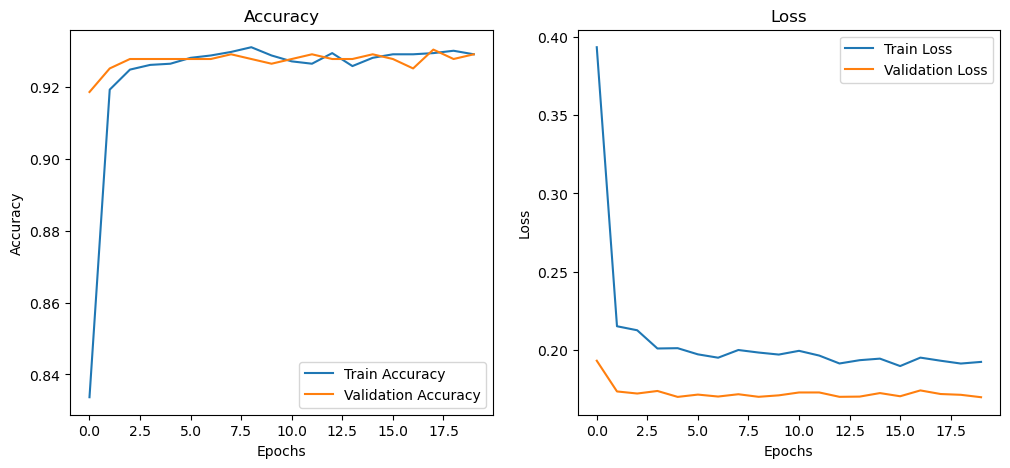

In [12]:
import matplotlib.pyplot as plt

# Plot de la précision
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


24/24 [==============================] - 0s 13ms/step


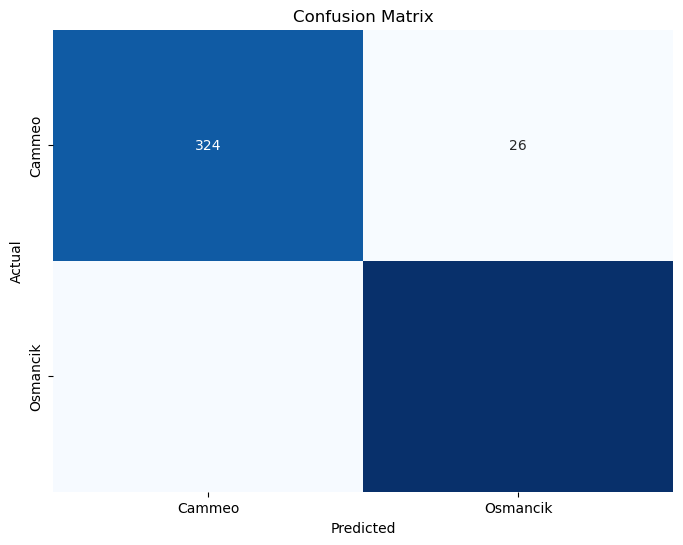

In [13]:


# Prédictions sur les données de test
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Tracé de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
X.head()

,Area Integer,Perimeter Real,Major_Axis_Length Real,Minor_Axis_Length Real,Eccentricity Real,Convex_Area Integer,Extent Real
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024
